In [ ]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Force TensorFlow to use CPU
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **1. Data Set Loading**

In [ ]:
# -----------------------------
# 1. Dataset Setup
# -----------------------------
data_dir_t = "/content/drive/MyDrive/Research-2/datasetn/train" # dataset/halt, dataset/freeze, dataset/pistol
data_dir_v = "/content/drive/MyDrive/Research-2/datasetn/validation" # dataset/halt, dataset/freeze, dataset/pistol
data_dir_test = "/content/drive/MyDrive/Research-2/datasetn/test"

img_size = (224, 224)
batch_size = 32

In [ ]:
import os
print("Files in datasetn:", os.listdir(data_dir_t))


Files in datasetn: ['pistol', 'freeze', 'halt']


## **2. Data Set Splitting & Augmentation**

In [ ]:
# # Use validation_split to automatically split data
# datagen = ImageDataGenerator(
#     rescale=1./255,              # Normalize pixel values to [0,1] for faster convergence
#     validation_split=0.2,        # Reserve 20% of data for validation
#     rotation_range=20,           # Randomly rotate images within 20 degrees
#     width_shift_range=0.2,       # Randomly shift images horizontally by up to 20% of width
#     height_shift_range=0.2,      # Randomly shift images vertically by up to 20% of height
#     shear_range=0.2,             # Apply random shearing transformations (slanting the image)
#     zoom_range=0.2,              # Randomly zoom in/out up to 20%
#     horizontal_flip=True,        # Randomly flip images horizontally (mirror effect)
#     fill_mode="nearest",         # Fill empty pixels after rotation/shift using nearest pixel values
#     brightness_range=(0.7, 1.3), # Randomly adjust brightness between 70% (darker) and 130% (brighter)
#     channel_shift_range=30.0     # Randomly shift color channels to simulate lighting/color variations
# )


# train_generator = datagen.flow_from_directory(
#     data_dir,
#     target_size=img_size,
#     batch_size=batch_size,
#     shuffle=True,
#     class_mode="categorical",
#     subset="training"
# )

# val_generator = datagen.flow_from_directory(
#     data_dir,
#     target_size=img_size,
#     batch_size= 16,            # batchsize=16 used for validation to reduce memory usage during evaluation
#     shuffle=False,             # Don't shuffle validation data to maintain order for evaluation
#     class_mode="categorical",
#     subset="validation"
# )




Found 960 images belonging to 3 classes.
Found 237 images belonging to 3 classes.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# 1) Training: augmentation ON
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input, # rescale 1/255 is also avilable inside preprocessing unit
    rotation_range=15,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0.8, 1.2),
    horizontal_flip=True
)

# 2) Validation/Test: augmentation OFF and only use Imagegen preprocessing steps.
val_datagen  = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_directory(
    data_dir_t,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    data_dir_v,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_gen = test_datagen.flow_from_directory(
    data_dir_test,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

Found 839 images belonging to 3 classes.
Found 180 images belonging to 3 classes.
Found 177 images belonging to 3 classes.


In [ ]:
print("Train batch size:", train_gen.batch_size)
print("Val batch size:", val_gen.batch_size)

Train batch size: 32
Val batch size: 32


In [ ]:
# Check distributions
train_classes, train_counts = np.unique(train_gen.classes, return_counts=True)
val_classes, val_counts = np.unique(val_gen.classes, return_counts=True)

print("Training set distribution:")
for cls, count in zip(train_classes, train_counts):
    print(f"{cls}: {count} images")

print("\nValidation set distribution:")
for cls, count in zip(val_classes, val_counts):
    print(f"{cls}: {count} images")


Training set distribution:
0: 280 images
1: 279 images
2: 280 images

Validation set distribution:
0: 60 images
1: 60 images
2: 60 images


## **3. Model Development**

In [ ]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization

In [ ]:
# -----------------------------
# 2. Model Setup (MobileNetV2)
# -----------------------------
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224,224,3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)   # Batch Normalization
x = Dropout(0.3)(x)
predictions = Dense(3, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=predictions)


print(train_gen.class_indices)
print(np.unique(train_gen.classes, return_counts=True))


{'freeze': 0, 'halt': 1, 'pistol': 2}
(array([0, 1, 2], dtype=int32), array([280, 279, 280]))


## **4. Model Training**

### **Stage-1**

In [ ]:
#-----------------------------
#3. Compile & Train
#-----------------------------



model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])


checkpoint = ModelCheckpoint(
    filepath="/content/drive/MyDrive/Research-2/best_hand_signal_model.keras",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    mode="min",
    verbose=1
)


history = model.fit(
    train_gen,
    validation_data = val_gen,
    epochs = 10,
    callbacks=[checkpoint]
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

import pickle

with open("history_stage1.pkl", "wb") as f:
    pickle.dump(history.history, f)

Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4716 - loss: 1.3514
Epoch 1: val_loss improved from inf to 0.97324, saving model to /content/drive/MyDrive/Research-2/best_hand_signal_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 104s 3s/step - accuracy: 0.4728 - loss: 1.3467 - val_accuracy: 0.5444 - val_loss: 0.9732
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5970 - loss: 1.0110
Epoch 2: val_loss improved from 0.97324 to 0.80911, saving model to /content/drive/MyDrive/Research-2/best_hand_signal_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.5979 - loss: 1.0077 - val_accuracy: 0.5778 - val_loss: 0.8091
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7174 - loss: 0.7245
Epoch 3: val_loss improved from 0.80911 to 0.66654, saving model to /content/drive/MyDrive/Research-2/best_hand_signal_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.7182 - loss: 0.7227 - val_accuracy: 0.6611 - val_loss: 0.6665
Epoch 4/10
27/27

### Learning Curves – Stage 1

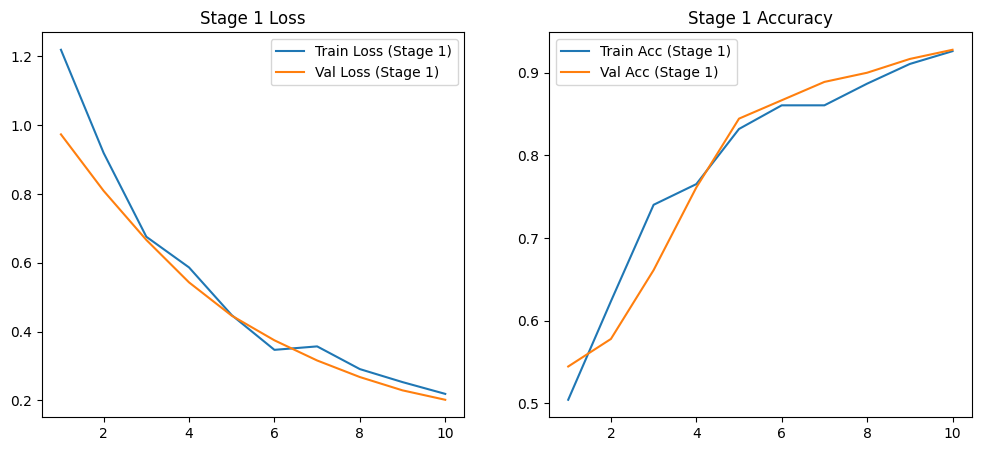

In [ ]:
#-----------------------------
#Learning Curves – Stage 1
#-----------------------------

import matplotlib.pyplot as plt

epochs = range(1, len(history.history['loss']) + 1)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, history.history['loss'], label='Train Loss (Stage 1)')
plt.plot(epochs, history.history['val_loss'], label='Val Loss (Stage 1)')
plt.legend()
plt.title('Stage 1 Loss')

plt.subplot(1,2,2)
plt.plot(epochs, history.history['accuracy'], label='Train Acc (Stage 1)')
plt.plot(epochs, history.history['val_accuracy'], label='Val Acc (Stage 1)')
plt.legend()
plt.title('Stage 1 Accuracy')

plt.show()

 ## **5. Fine-Tuning MobileNetV2**

In [ ]:
# -----------------------------
# Model Setup (MobileNetV2) for Fine-Tuned
# -----------------------------
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224,224,3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense( 128, activation="relu", kernel_regularizer=regularizers.l2(0.001))(x)
x = BatchNormalization()(x)   # Batch Normalization
x = Dropout(0.5)(x)
predictions = Dense(3, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=predictions)


print(train_gen.class_indices)
print(np.unique(train_gen.classes, return_counts=True))


{'freeze': 0, 'halt': 1, 'pistol': 2}
(array([0, 1, 2], dtype=int32), array([280, 279, 280]))


In [ ]:
# -----------------------------
# 5. Fine-tuning MobileNetV2
# -----------------------------

# base_model = model.layers[0]   # MobileNetV2
base_model.trainable = True

# Freeze early layers, train deeper layers
for layer in base_model.layers[:100]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.000005),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

checkpoint = ModelCheckpoint(
    filepath="/content/drive/MyDrive/Research-2/best_hand_signal_model.keras",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    mode="min",
    verbose=1
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)


history_finetune = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=60,
    callbacks=[checkpoint, early_stop]
)



import pickle

with open("history_finetune.pkl", "wb") as f:
    pickle.dump(history_finetune.history, f)

Epoch 1/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4391 - loss: 1.8084
Epoch 1: val_loss improved from inf to 1.48526, saving model to /content/drive/MyDrive/Research-2/best_hand_signal_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 123s 4s/step - accuracy: 0.4388 - loss: 1.8076 - val_accuracy: 0.3556 - val_loss: 1.4853
Epoch 2/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4892 - loss: 1.6123
Epoch 2: val_loss improved from 1.48526 to 1.38276, saving model to /content/drive/MyDrive/Research-2/best_hand_signal_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.4899 - loss: 1.6098 - val_accuracy: 0.3889 - val_loss: 1.3828
Epoch 3/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5593 - loss: 1.3717
Epoch 3: val_loss improved from 1.38276 to 1.28168, saving model to /content/drive/MyDrive/Research-2/best_hand_signal_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.5607 - loss: 1.3691 - val_accuracy: 0.4611 - val_loss: 1.2817
Epoch 4/60
27/27

### Learning Curves – Fine-Tuning

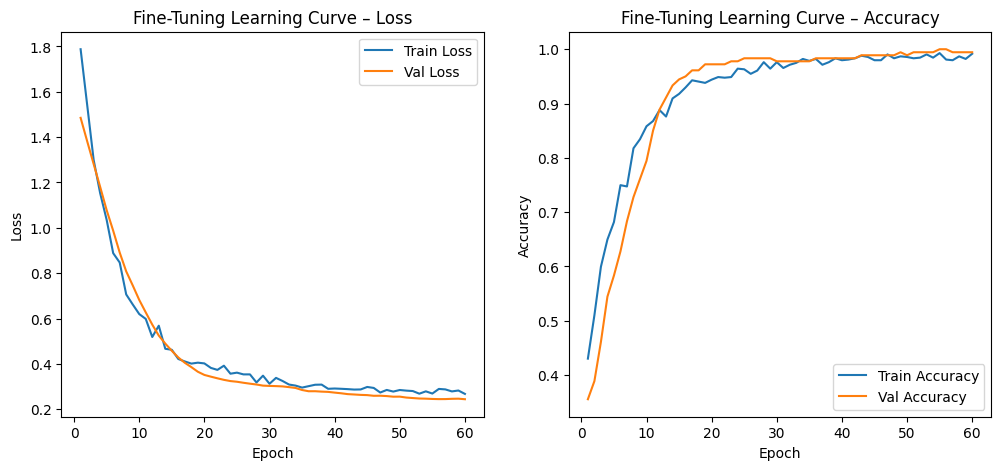

In [ ]:
# -----------------------------
# Learning Curves – Fine-Tuning
# -----------------------------

import matplotlib.pyplot as plt

epochs = range(1, len(history_finetune.history['loss']) + 1)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, history_finetune.history['loss'], label='Train Loss')
plt.plot(epochs, history_finetune.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Fine-Tuning Learning Curve – Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, history_finetune.history['accuracy'], label='Train Accuracy')
plt.plot(epochs, history_finetune.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Fine-Tuning Learning Curve – Accuracy')
plt.legend()

plt.show()


##  **6. Testing Phrase**

### Test the model using one image

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

# Load trained model
model = tf.keras.models.load_model("/content/drive/MyDrive/Research-2/best_hand_signal_model.keras")

# Class labels (must match your training generator)
class_names = ["freeze", "halt", "pistol"]

# Load and preprocess single image
img_path = "/content/drive/MyDrive/Research-2/datasetn/test/pistol/IMG_7939.jpg"   # replace with your test image path
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)  # batch dimension

# Predict
pred = model.predict(img_array)
pred_class = class_names[np.argmax(pred)]

print("Predicted class:", pred_class)
print("Raw probabilities:", pred)





1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
Predicted class: pistol
Raw probabilities: [[0.00237793 0.03070514 0.966917  ]]


### Classification Report

In [ ]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

tf.keras.backend.clear_session()

model = tf.keras.models.load_model("/content/drive/MyDrive/Research-2/best_hand_signal_model.keras", compile=False)

test_gen.reset()

steps = int(np.ceil(test_gen.samples / test_gen.batch_size))

# CREATE LIST
y_pred_list = []

for _ in range(steps):
    x_batch, _ = next(val_gen)
    probs = model.predict(x_batch, verbose=0)
    y_pred_list.append(np.argmax(probs, axis=1))

# CONCATENATE ALL BATCH PREDICTIONS
y_pred = np.concatenate(y_pred_list)[:test_gen.samples]

y_true = test_gen.classes

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred, average='macro', zero_division=0))
print("Recall:", recall_score(y_true, y_pred, average='macro', zero_division=0))
print("F1-score:", f1_score(y_true, y_pred, average='macro', zero_division=0))
print(classification_report(
    y_true,
    y_pred,
    target_names=list(test_gen.class_indices.keys()),
    zero_division=0
))


Accuracy: 0.9774011299435028
Precision: 0.9777716032231175
Recall: 0.9774011299435029
F1-score: 0.9773978829794142
              precision    recall  f1-score   support

      freeze       0.97      1.00      0.98        59
        halt       0.97      0.97      0.97        59
      pistol       1.00      0.97      0.98        59

    accuracy                           0.98       177
   macro avg       0.98      0.98      0.98       177
weighted avg       0.98      0.98      0.98       177



### Confusion Matrix

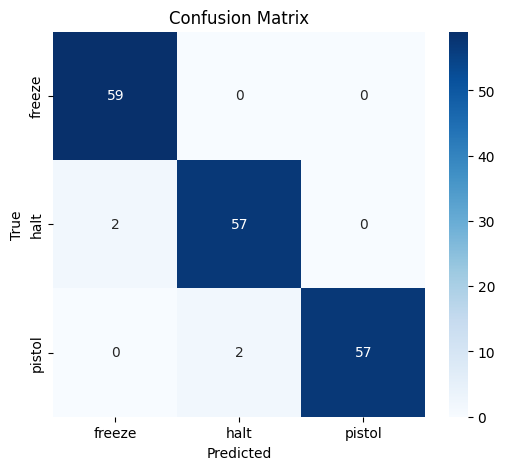

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_true, y_pred)
labels = list(test_gen.class_indices.keys())

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
